 Start with something simple, 2D, and only slightly nongaussian.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

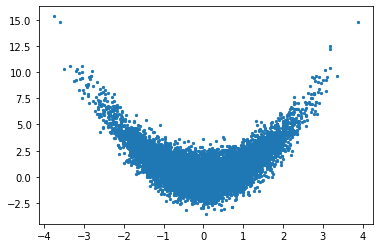

In [3]:
# Sample from the initial distribution
nsamples=10000
X = np.random.normal(0, 1, nsamples) 
Y = np.random.normal(X**2,1,nsamples)

plt.scatter(X,Y,s=5)


The example here is just going to be two 2d gaussians. Now to set up the MADE.


In [4]:
# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[12,12], activation='sigmoid') # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

target_distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata = np.stack([X, Y], axis=-1)
ydata = base_distribution.sample(nsamples)
#print(data)
#plt.scatter(X,Y,s=5)

batch_size = 100
model.fit(x=xdata,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=50,  # Usually `n // batch_size`.
          validation_split=0.3,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100


2022-03-16 13:40:09.359170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 13:40:09.377258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 13:40:09.377378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 13:40:09.377742: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

50/50 [==============================] - 1s 4ms/step - loss: 4.0690 - val_loss: 3.4955
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 3.4566 - val_loss: 3.3712
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 3.4116 - val_loss: 3.3526
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 3.3796 - val_loss: 3.3497
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 3.4180 - val_loss: 3.3506
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 3.3233 - val_loss: 3.3479
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 3.4177 - val_loss: 3.3498
Epoch 8/100
50/50 [==============================] - 0s 2ms/step - loss: 3.3788 - val_loss: 3.3493
Epoch 9/100
50/50 [==============================] - 0s 1ms/step - loss: 3.3625 - val_loss: 3.3479
Epoch 10/100
50/50 [==============================] - 0s 1ms/step - loss: 3.4043 - val_loss: 3.3492
Epoch 11/100
50/50 [=

50/50 [==============================] - 0s 2ms/step - loss: 2.9581 - val_loss: 2.9010
Epoch 84/100
50/50 [==============================] - 0s 2ms/step - loss: 2.9233 - val_loss: 2.8983
Epoch 85/100
50/50 [==============================] - 0s 2ms/step - loss: 2.9429 - val_loss: 2.8952
Epoch 86/100
50/50 [==============================] - 0s 2ms/step - loss: 2.9025 - val_loss: 2.8901
Epoch 87/100
50/50 [==============================] - 0s 2ms/step - loss: 2.9280 - val_loss: 2.8880
Epoch 88/100
50/50 [==============================] - 0s 1ms/step - loss: 2.9132 - val_loss: 2.8842
Epoch 89/100
50/50 [==============================] - 0s 1ms/step - loss: 2.9130 - val_loss: 2.8815
Epoch 90/100
50/50 [==============================] - 0s 1ms/step - loss: 2.9246 - val_loss: 2.8797
Epoch 91/100
50/50 [==============================] - 0s 1ms/step - loss: 2.9064 - val_loss: 2.8761
Epoch 92/100
50/50 [==============================] - 0s 1ms/step - loss: 2.9121 - val_loss: 2.8760
Epoch 93/100


tf.Tensor(
[[ 1.3873911  -0.10618687]
 [ 0.11837004 -2.8971415 ]
 [ 1.031131   -0.16956034]
 ...
 [ 0.77182555 -0.5464053 ]
 [-0.44524047  0.79659694]
 [ 0.43154407 -0.15214004]], shape=(1000, 2), dtype=float32)
tf.Tensor(
[[ 1.3734353   1.8408673 ]
 [ 0.11812012 -2.655665  ]
 [ 1.0210229   0.8617773 ]
 ...
 [ 0.764518    0.01085234]
 [-0.43940318  0.98833495]
 [ 0.42791173  0.03230971]], shape=(1000, 2), dtype=float32)


(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  4.,  3.,  0.,  0.,  1.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  2.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  1.,  1.,  5.,  7.,  3., 12.,  6.,  5.,  2.,  1.,
          0.,  0.],
        [ 0.,  0.,  1.,  0.,  5.,  4.,  3.,  9.,  9., 12.,  3.,  3.,  1.,
          1.,  1.],
        [ 0.,  0.,  1.,  5.,  7.,  8.,  8., 15., 17., 21.,  6., 11.,  5.,
          1.,  1.],
        [ 0.,  1.,  1.,  4., 11., 19.,  9., 22., 24., 14., 10., 11.,  0.,
          2.,  0.],
        [ 2.,  0.,  3.,  6., 11., 21., 25., 22., 25., 24., 17., 16.,  4.,
          6.,  0.],
        [ 1.,  2.,  1.,  3., 15., 13., 24., 21., 19., 25., 16., 12.,  6.,
          0.,  0.],
        [ 1.,  1.,  1.,  2.,  5., 19., 21., 18., 19., 21., 12.,  8.,  7.,
          4.,  0.],
        [ 0.,  0.,  2.,  4.,  8.,  8., 19., 21.,  9., 15.,  4.,  6.,  1.,
          2.,  0.],
        [ 0.,  0.,  0.,  2.,  0.,  6.,  8., 10.,  5.,  4.,  

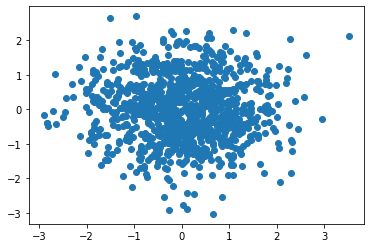

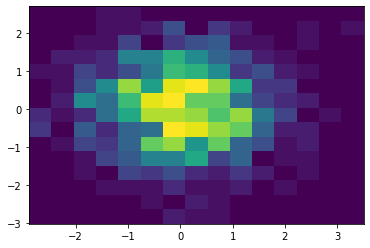

In [5]:
# Use the fitted distribution.
s=1000
samples = base_distribution.sample((s,2))
print(samples)
#print(samples)
#distribution.log_prob(np.ones((3, 2), dtype=np.float32))
#print(samples)
mapping = target_distribution.bijector.forward(samples)
print(mapping)

x,y=[],[]

for i in range(0,s):
    x.append(float(samples[i][0]))
    y.append(float(samples[i][1]))
    
x_map = mapping[...,0]
y_map = mapping[...,1]

fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
ax1.scatter(x,y)
ax2.hist2d(x,y,bins=[15,15])

Looks pretty Gausian! Now lets apply a fit, determine the full gaussian map, and plot some contours.

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   9.,   2.,   0.,   0.,   0.],
        [  0.,   0.,   3.,  20.,  30.,  23.,   4.,   1.,   0.],
        [  0.,   1.,  17.,  46.,  75.,  61.,  15.,   1.,   0.],
        [  0.,   6.,  19.,  88., 114.,  98.,  20.,   2.,   0.],
        [  0.,   2.,  14.,  76.,  82.,  60.,  26.,   1.,   0.],
        [  0.,   0.,   3.,  14.,  30.,  19.,   3.,   1.,   0.],
        [  0.,   0.,   1.,   5.,   3.,   1.,   2.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.]]),
 array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
         0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ]),
 array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
         0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ]),
 <matplotlib.collections.QuadMesh at 0x7fbf502b7c40>)

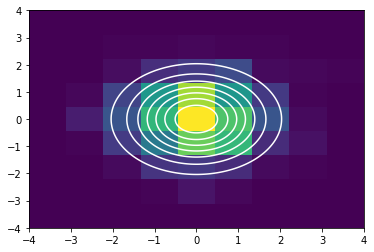

In [6]:
from scipy.stats import multivariate_normal

dist_x, dist_y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((dist_x, dist_y))
rv = multivariate_normal([0., 0.], [[1.0, 0.], [0., 1.0]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contour(dist_x, dist_y, rv.pdf(pos),colors='w')
ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])

In [7]:
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[0])
results = np.stack(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[0])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[1])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[2])
binx=[]
biny=[]
edge_x = ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[1]
edge_y = ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[2]

for i in range(len(edge_x)-1):
    binx.append((edge_x[i+1]-edge_x[i])/2 + edge_x[i])
for i in range(len(edge_y)-1):
    biny.append((edge_y[i+1]-edge_y[i])/2 + edge_y[i])

bins=[]
z=[]
#bins.append(binx)
#bins.append(biny)
xvals = []
yvals = []

for i in range(len(binx)-1):
    for j in range(len(biny)-1):
        xvals.append(binx[i])
        yvals.append(biny[j])
        z.append(results[i][j])
        
#print(xvals)
#print(yvals)
#print(z)

In [8]:
# Thanks https://stackoverflow.com/questions/52148141/2d-gaussian-fit-using-lmfit 
# since it has been so long since I used lmfit
from lmfit import Parameters, minimize, report_fit

def gaussian2D(x, y, cen_x, cen_y, sig_x, sig_y):
    return np.exp(-(((cen_x-x)/sig_x)**2 + ((cen_y-y)/sig_y)**2)/2.0)

def residuals(p, x, y, z):
    height = p["height"].value
    cen_x = p["centroid_x"].value
    cen_y = p["centroid_y"].value
    sigma_x = p["sigma_x"].value
    sigma_y = p["sigma_y"].value
    return (z - height*gaussian2D(x,y, cen_x, cen_y, sigma_x, sigma_y))

initial = Parameters()
initial.add("height",value=1.)
initial.add("centroid_x",value=0.)
initial.add("centroid_y",value=0.)
initial.add("sigma_x",value=1.)
initial.add("sigma_y",value=1.)

fit = minimize(residuals, initial, args=(xvals,yvals, z))
print(report_fit(fit))

# need to implement a covariance term in the model

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 106
    # data points      = 64
    # variables        = 5
    chi-square         = 1083.56861
    reduced chi-square = 18.3655697
    Akaike info crit   = 191.064452
    Bayesian info crit = 201.858867
[[Variables]]
    height:      122.248844 +/- 2.96396805 (2.42%) (init = 1)
    centroid_x:  0.05555051 +/- 0.02489614 (44.82%) (init = 0)
    centroid_y:  0.03563027 +/- 0.02483247 (69.69%) (init = 0)
    sigma_x:    -1.02664343 +/- 0.02489431 (2.42%) (init = 1)
    sigma_y:     1.02407439 +/- 0.02482736 (2.42%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(height, sigma_x) = 0.500
    C(height, sigma_y) = -0.500
None


(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   9.,   2.,   0.,   0.,   0.],
        [  0.,   0.,   3.,  20.,  30.,  23.,   4.,   1.,   0.],
        [  0.,   1.,  17.,  46.,  75.,  61.,  15.,   1.,   0.],
        [  0.,   6.,  19.,  88., 114.,  98.,  20.,   2.,   0.],
        [  0.,   2.,  14.,  76.,  82.,  60.,  26.,   1.,   0.],
        [  0.,   0.,   3.,  14.,  30.,  19.,   3.,   1.,   0.],
        [  0.,   0.,   1.,   5.,   3.,   1.,   2.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.]]),
 array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
         0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ]),
 array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
         0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ]),
 <matplotlib.collections.QuadMesh at 0x7fbf50324550>)

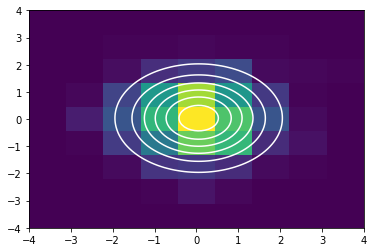

In [9]:
Xvals = np.linspace(-4,4,100)
Yvals = np.linspace(-4,4,100)
Xvals,Yvals = np.meshgrid(Xvals, Yvals)

xo = fit.params["centroid_x"].value
yo = fit.params["centroid_y"].value
sx = fit.params["sigma_x"].value
sy = fit.params["sigma_y"].value

Z=gaussian2D(Xvals,Yvals,xo,yo,sx,sy)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.contour(Xvals, Yvals, Z,colors='w')
ax3.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])

Now lets evaluate the NN fit. First I will take the sampled data and map it back to the non-gaussian parameter space. Then I will map the contours of the gaussian fit to the non-gaussian parameter space.

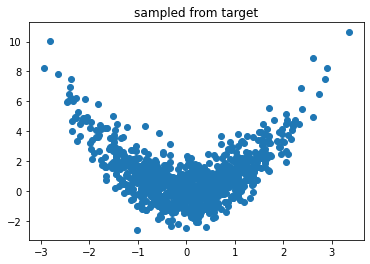

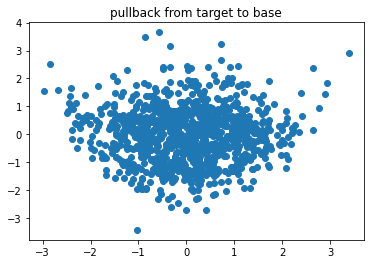

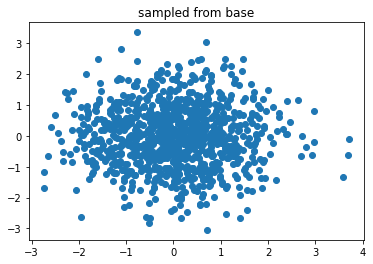

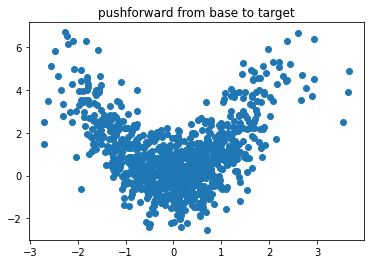

In [13]:
# resample from target distribution
X = np.random.normal(0, 1, 1000) 
Y = np.random.normal(X**2,1,1000)

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y)
ax2.scatter(pb_x,pb_y)
ax3.scatter(x,y)
ax4.scatter(pf_x,pf_y)

Cool!

In [84]:
x_points , y_points = np.mgrid[-3:3:.05, -3:3:.05]
xy_points = np.stack((x_points, y_points),axis=-1)
print(x_points)
print(y_points)
z_vals=gaussian2D(x_points,y_points,xo,yo,sx,sy)
x_pos=[]
y_pos=[]

#for i in range(len(x_points)):
#    for j in range(len(y_points)):
#        pos=xy_points[i][j]
#        z_vals.append(gaussian2D(pos[0],pos[1],xo,yo,sx,sy))
#        append to list to use when evaluating NN model
#        x_pos.append(pos[0])
#        y_pos.append(pos[1])

# pushforward points to target distribution
contour_pushforward = target_distribution.bijector.forward(tf.cast(xy_points,tf.float32))

contour_x = contour_pushforward[...,0].numpy()
contour_y = contour_pushforward[...,1].numpy()
    
#np.stack((contour_x,contour_y),axis=-1)
print(contour_x)
print(contour_y)

[[-3.   -3.   -3.   ... -3.   -3.   -3.  ]
 [-2.95 -2.95 -2.95 ... -2.95 -2.95 -2.95]
 [-2.9  -2.9  -2.9  ... -2.9  -2.9  -2.9 ]
 ...
 [ 2.85  2.85  2.85 ...  2.85  2.85  2.85]
 [ 2.9   2.9   2.9  ...  2.9   2.9   2.9 ]
 [ 2.95  2.95  2.95 ...  2.95  2.95  2.95]]
[[-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 ...
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]]
[[-2.9665701 -2.9665701 -2.9665701 ... -2.9665701 -2.9665701 -2.9665701]
 [-2.9171102 -2.9171102 -2.9171102 ... -2.9171102 -2.9171102 -2.9171102]
 [-2.8676503 -2.8676503 -2.8676503 ... -2.8676503 -2.8676503 -2.8676503]
 ...
 [ 2.8202472  2.8202472  2.8202472 ...  2.8202472  2.8202472  2.8202472]
 [ 2.8697073  2.8697073  2.8697073 ...  2.8697073  2.8697073  2.8697073]
 [ 2.9191673  2.9191673  2.9191673 ...  2.9191673  2.9191673  2.9191673]]
[[-1.1686015  -1.0653772  -0

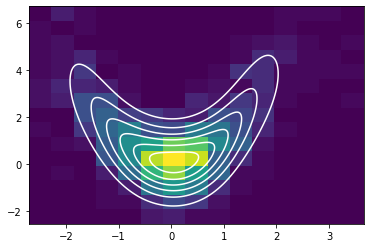

In [88]:
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.contour(contour_x,contour_y,z_vals,colors='w')

In the plot above, what I did was take the gaussian contours and map them under the bijector from the neural net. We can see that this matches well with the initial generated distribution